In [86]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import datetime as dt
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [87]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [88]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [89]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [90]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [91]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [92]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [93]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

In [94]:
#upon reviewing the data, we notice that it's not actualized based on current year, so we'll print out the most recent date available and extract the last 365 days since then

In [95]:
#https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Timedelta.html
from datetime import timedelta

In [96]:
#pull most recent date
precip_date = precip_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first().date


precip_date = dt.datetime.strptime(precip_date, "%Y-%m-%d")


In [97]:
#using timedelta datetime to calculate a year before our precip_date
precip_first_date = precip_date - timedelta(days=365)

In [98]:
#now let's find out what's the first day of data
precip_first_date

datetime.datetime(2016, 8, 23, 0, 0)

In [99]:
#and last?
precip_date

datetime.datetime(2017, 8, 23, 0, 0)

In [100]:
#now we can filter our data based on the above dates
precip_analysis = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23").\
    filter(Measurement.date <= "2017-08-23").all()

In [101]:
#set & print dataframe
precipitation_df = pd.DataFrame(precip_analysis)
precipitation_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


<function matplotlib.pyplot.show(*args, **kw)>

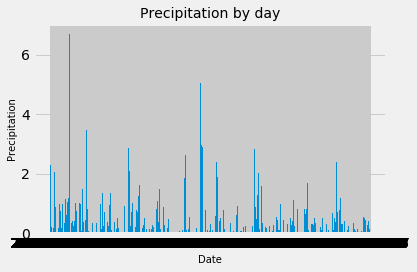

In [102]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax1 = plt.subplots()

plt.bar(precipitation_df['date'], precipitation_df['prcp'])
plt.title("Precipitation by day", fontsize=14)
plt.xticks(precipitation_df['date'])
plt.xlabel("Date", fontsize=10)
plt.ylabel("Precipitation", fontsize=10)
plt.tight_layout()

fig.savefig('Output/precipitation.png', dpi=fig.dpi)

plt.show

![precipitation](Images/precipitation.png)

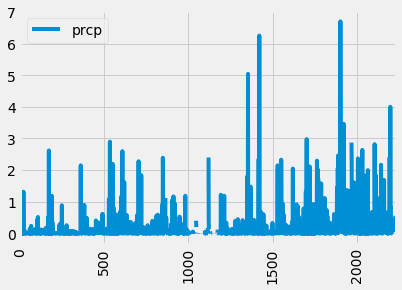

In [103]:
#getting weird black bar so also plotting like this:
precipitation_df.plot(rot=90)

In [104]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [105]:
# Design a query to show how many stations are available in this dataset?
station_numb = session.query(func.count(Station.station)).all()
print(station_numb)

[(9,)]


In [106]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Station.station, func.count(Station.id)).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Station.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [107]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), 
              func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").\
    group_by(Measurement.station).all()

[(54.0, 85.0, 71.66378066378067)]

In [108]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.station, func.count(Measurement.prcp))\
             .group_by(Measurement.station)\
             .filter(Measurement.date <= "2017-08-23").all()\


In [109]:
#loop through stations
for station in temp_obs:
    print(station)

# Store
top_station = temp_obs[0][0]

('USC00511918', 1932)
('USC00513117', 2696)
('USC00514830', 1937)
('USC00516128', 2484)
('USC00517948', 683)
('USC00518838', 342)
('USC00519281', 2772)
('USC00519397', 2685)
('USC00519523', 2572)


In [110]:
tobs_result = session.query(Measurement.tobs)\
               .filter(Measurement.station == top_station)
#Make a list to make life easy
tobs_data = []
for row in tobs_result:
    tobs_data.append(row[0])

<function matplotlib.pyplot.show(*args, **kw)>

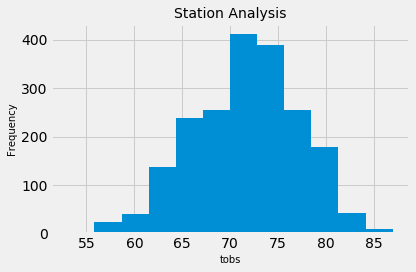

In [111]:
plt.hist(tobs_data, bins=12, label='tobs')
plt.title("Station Analysis", fontsize=14)
plt.xlabel("tobs", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.tight_layout()

fig.savefig('Output/station.png', dpi=fig.dpi)

plt.show

![precipitation](Images/station-histogram.png)

In [112]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]
